In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import Ridge


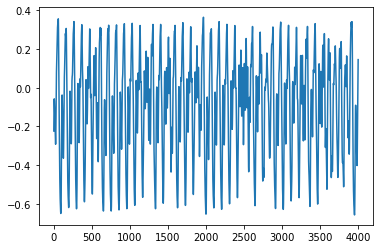

In [2]:

# check for intuition at http://users.fs.cvut.cz/ivo.bukovsky/PVVR/prace_studentu/Mackey_Glass_time_series_prediction_Fuzzy_Lookup.pdf

def mackey_glass(tau, length):
    betta=0.2
    gamma = 0.1 
    a=10
    delay=100 # will cut these initial steps
    
    y=np.random.rand(tau) # random intial values between 0 and 1
    # Euler's method to solve the differential equation
    for t in range(tau-1, length+delay+tau-1):
        current= y[t] + ( betta * y[t-(tau-1)]   / ( 1 + np.power(y[t-(tau-1)], a)   )  ) - gamma*y[t]   
        y=np.append(y, current)
    
    y=y-1 # get rid of mean
    y=np.tanh(y) # squeze with tanh    
    
    return y[tau+delay:length+delay+tau] # return the last length elements


length=4000 # duration of the series
tau=30 # delay in the equation

y=mackey_glass(tau, length)
#plot generated time-series
plt.plot(y)
plt.show()

In [19]:
def plot_training_data(train_input, train_target, input_color='yellow', target_color='cyan', facecolor='black', figsize=(20,10)):
    (fig, axs) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axs[0].set_title('training input')
    axs[0].plot(train_input, color=input_color)
    axs[0].set_facecolor(facecolor)
    axs[1].set_title('target output')
    axs[1].plot(train_target, color=target_color)
    axs[1].set_facecolor(facecolor)
    plt.show()

def plot_outputs(target, output, test_input=None, output_color='magenta', input_color='yellow', target_color='cyan', error_color='red', facecolor='black', figsize=(20,10)):
    (fig, ax) = plt.subplots(figsize=figsize)
    ax.set_facecolor(facecolor)
    ax.plot(target, color=target_color, linewidth=4)
    ax.plot(output, color=output_color, linewidth=1.5)
    error = np.abs(output - target)
    ax.plot(error, color=error_color)
    if test_input is not None:
        ax.plot(test_input, color=input_color, linestyle='dotted')
    plt.show()

def plot_weight_matrix(w, ax=None, shape=None, figsize=(20,5)):
    if shape is not None:
        w = np.resize(w, shape)
    if ax is None:
        (fig, ax) = plt.subplots(figsize=figsize)
    ax.imshow(w, cmap='gray')
    if ax is None:
        plt.show()

def plot_initial_esn(win, w, win_shape=None, figsize=(20,5)):
    (fig, axs) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    ax = axs[0]
    ax.set_title('Input weights Win')
    plot_weight_matrix(win, ax=ax, shape=win_shape)
    ax = axs[1]
    ax.set_title('RNN weights W')
    plot_weight_matrix(w, ax=ax)
    plt.show()

def plot_rnn_states(xs, shape, figsize=(20,10)):
    """Plot selected RNN states as images."""
    n = xs.shape[0]
    examples = [0, n//10, -n//10, -1]
    ncols = len(examples)
    (fig, axs) = plt.subplots(nrows=1, ncols=ncols, figsize=figsize)
    for (n,i) in enumerate(examples):
        title = f'xs[{i}]'
        x = np.resize(xs[i], shape)
        axs[n].set_title(title)
        axs[n].imshow(x, cmap='gray')
    plt.show()

def plot_all_rnn_states(xs, figsize=(20,10)):
    """
    Plot all RNN states as a single image, with one state per column.
    Takes a matrix where each row is one RNN state (one x vector).
    """
    lengths = np.sqrt(np.sum(np.square(xs), axis=1)) # length of each x vector
    extent = [-0.5, len(lengths)-0.5, np.min(lengths), np.max(lengths)]
    xs = np.transpose(xs)
    (fig, ax) = plt.subplots(figsize=figsize)
    ax.set_title('All RNN state vectors and their lengths')
    ax.imshow(xs, cmap='gray')#, extent=extent)
    ax.plot(lengths, color='orange', marker='o', markersize=1)
    plt.show()


1. What does teacher forcing mean?
    - TF means that instead of feeding the feedbackloop with earlier predictions, we feed it with our desired output during training to cancel the recurrency. 
2. What is ridge regression? Why is it useful? 
    - Technique for analyzing multiple regression data that suffers multicollinearity. 
3. How to achieve echo state property?
    - p(W) < 1 should ensure ESP. p(W) = spectral radius. 
4. What is Root-Mean-Square Error (RMSE)?
    - Meaure of deviation.

In [74]:

res_size = 1000 #1000 neurons
scale = 0.2
weight_in = np.random.uniform(-1,1,(res_size,2))*scale
bias = 1
p = 0.5
weight_res = np.random.uniform(0,1,(res_size,res_size))

In [75]:
def tanh(x):
    return np.tanh(x).real

In [76]:
#Reservoir weight config
eg_val1 = np.linalg.eigvals(weight_res)
weight_res = weight_res/(max(eg_val1))*p

eg_val2 = np.linalg.eigvals(weight_res)

print(np.real(max(eg_val2))<= p+0.01)


True


In [77]:
#create training set
tr_set = []
test_set = []

print("Input weight size", weight_in.shape)

#Create input layer
for n in range(1,3000):
    u = 0.5*np.sin(n/4)
    tr_set.append(u) 

#Create testing set
for n in range(3000,4000):
    u = 0.5*np.sin(n/4)
    test_set.append(u)
    
#Convert to numpy data structure    
tr_set = np.array(tr_set)
test_set = np.array(test_set)

#Create reservoir


Input weight size (1000, 2)


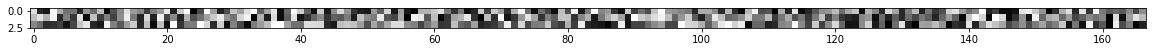

In [83]:
#W_out and W_back setup
weight_out = np.random.uniform(0,1,(1,(res_size+1+1)))*scale
plot_weight_matrix(weight_out, shape=[3,167])
weight_back = np.random.uniform(0,1,(res_size,1))*scale

one = np.array([1])

#Train network
x = np.zeros(1000)
y = np.zeros(1)
reg_X = []
reg_Y = []

rr = Ridge()

for i in range(1,1000):
    #kallstart med yamahan
    u = np.array([tr_set[i],bias])
    
    res_dot = np.dot(weight_res,x)
    in_dot = np.dot(weight_in,u)
    back_dot = np.dot(weight_back,y)

    x = tanh(res_dot + in_dot + back_dot)
    conc = np.concatenate([u, x])
    y = tanh(np.dot(weight_out,conc))
    
    

for i in range(1000,2998):
    #Varmstart
    u = np.array([tr_set[i],bias])
    
    res_dot = np.dot(weight_res, x)
    in_dot = np.dot(weight_in,u)
    back_dot = np.dot(weight_back,np.array([tr_set[i-1]]).real)
    
    conc = np.concatenate([u, x])

    x = tanh(res_dot + in_dot + back_dot)
    y = np.array(tanh(np.dot(weight_out,conc)).real)
    
    y_target = np.array([tr_set[i+1]]).real
    reg_X.append(conc)
    reg_Y.append(y_target)

rr.fit(reg_X, reg_Y)
weight_out = rr.coef_



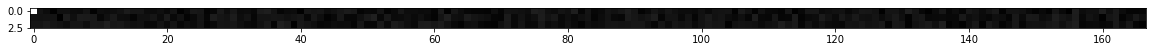

In [84]:
plot_weight_matrix(weight_out, shape=[3,167])


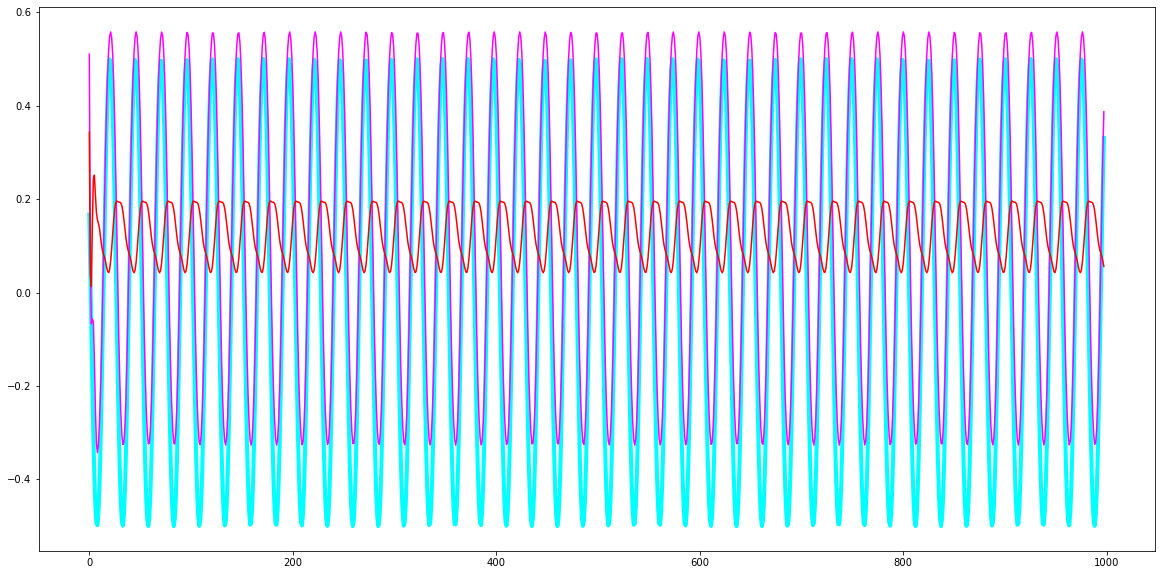

In [82]:
y_tot = []
y_target_tot = []
for i in range(1,999):
    #Varmstart
    u = np.array([test_set[i],bias])
    
    res_dot = np.dot(weight_res, x)
    in_dot = np.dot(weight_in,u)
    back_dot = np.dot(weight_back,y)
    
    conc = np.concatenate([u, x])

    x = tanh(res_dot + in_dot + back_dot)
    y = np.array(tanh(np.dot(weight_out,conc)).real)
    
    y_target = np.array([test_set[i+1]]).real
    #print(np.abs(y-y_target))
    y_tot.append(y)
    y_target_tot.append(y_target)
    
    
plot_outputs(np.array(y_target_tot), np.array(y_tot), facecolor='white')
    